# 1. MoE v/s Hyper-MoE on IRIS

This notebook investigates the difference between learning uncorrelated functions versus correlated functions (1).

- In uncorrelated functions $f_1, ..., f_k$, each expert $f_i$ is independently learnt and has different inputs.

- Conversely, correlated functions are $g_1, ..., g_k$ where $\forall 1 \leq i \leq k, g_i = \phi(c_i)$. Here $\phi$ is a generating function common for all $i$, that maps the condition $c_i$ to the functions $g_i$. Thus there is some dependence by construction.

Recall Mixture-of-Expert (MoE) layers. Each MoE-layer consists of uncorrelated functions or experts, each of which receive a partition of the input space and the outputs of all the experts are aggregated and used towards some task/objective. This design of MoEs presents a good arena to test out our main question (1).

### Normal MoE:

For a particular input sample $x$,
1. Pass each partition of $x$ through each expert, i.e., obtain $f_i(x_i)$.
2. Aggregate expert outputs via concatenation, i.e., final output is $o = [f_1(x_1), ... f_k(x_k)]$.

### Hyper-MoE

 We can represent the process of obtaining correlated experts $g_1, ..., g_k$ via the hypernetwork $\phi$ which uses a condition $c_i$ to generate $g_i$. The hypernetwork is common across all experts and is used to process an input sample $x$ as,

 1. Pass each partition of $x$ through each expert, i.e., obtain $g_i(x_i) = \phi(c_i)(x_i)$.
 2. Aggregate expert outputs via concatenation, i.e., final output is $\tilde{o} = [\phi(c_1)(x_1), ..., \phi(c_k)(x_k)]$.


 We use $o$ and $\tilde{o}$ to classify the sample $x$ for the Normal MoE layer and Hyper-MoE respectively, and use the IRIS dataset to test this out.


# 2. Experiments and analyses

## 2.0 Imports

In [111]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

## 2.1 Define MLP, HyperNetwork, and MoE models

### MLP

Standard issue multi-layer perceptron with the GELU activation between layers.

### HyperNetwork

Since this is supposed to predict experts which are MLPs, we predict each layer of the $k$ MLPs through a common generating function, hence for an MLP with $L$ layers, the params are $\boldsymbol{\theta} = [\theta_j]_{j=1}^L$. So, our hypernetwork will have $L$ generating functions $\boldsymbol{\phi} = [\phi_j]_{j=1}^L$. Using this, a condition $c_i$ will yield $g_i$ via $g_i = \boldsymbol{\phi}(c_i) = [\phi_j(c_i)]_{j=1}^L$. Can be optimized and tinkered with subsequently.

### MoE models

1. Input sample goes to an MoE layer (either Normal or Hyper)
2. Output of MoE layer goes to a linear classifier.
3. Output of linear classifier goes into a Cross Entropy Loss.

In [112]:
class MLP(nn.Module):
    def __init__(self, input_dim, intermediate_dims, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.intermediate_dims = intermediate_dims # list of ints
        self.output_dim = output_dim
        self.num_layers = len(intermediate_dims) + 1

        self.layers = []
        current_dim = input_dim
        next_dims = intermediate_dims + [output_dim]

        for i in range(self.num_layers):
            self.layers.append(nn.Linear(current_dim, next_dims[i]))
            current_dim = next_dims[i]

            if i != self.num_layers - 1:
                self.layers.append(nn.GELU())

        self.layers = nn.ModuleList(self.layers)

    def forward(self, x, multi_stage=False):
        out = []
        if multi_stage:
            for layer in self.layers:
                x = layer(x)
                out.append(x)
        else:
            for layer in self.layers:
                x = layer(x)
            out = x

        return out


class HyperNetwork(nn.Module):
    def __init__(self, param_shapes, cond_emb_dim, num_conds, expansion_factor=4):
        """
        param_shapes: if the target network has N layers then
        [
            [ [w_1.shape[0], w_1.shape[1]], [b_1.shape[0]] ] --> layer 1
            ...
            [ [w_N.shape[0], w_N.shape[1]], [b_N.shape[0]] ] --> layer N
        ]
        """
        super().__init__()
        self.param_shapes = param_shapes
        self.cond_embs = nn.Embedding(num_conds, cond_emb_dim)
        self.expansion_factor = expansion_factor

        self.num_target_layers = len(param_shapes)
        self.cond_mapper = MLP(cond_emb_dim, [expansion_factor * cond_emb_dim for _ in range(self.num_target_layers-1)], expansion_factor*cond_emb_dim)

        self.weight_decoders = []
        self.bias_decoders = []

        for i in range(self.num_target_layers):
            output_param_shape = param_shapes[i][0][0] * param_shapes[i][0][1]
            decoder = nn.Linear(expansion_factor*cond_emb_dim, output_param_shape)
            self.weight_decoders.append(decoder)

            output_param_shape = param_shapes[i][1][0]
            decoder = nn.Linear(expansion_factor*cond_emb_dim, output_param_shape)
            self.bias_decoders.append(decoder)

        self.weight_decoders = nn.ModuleList(self.weight_decoders)
        self.bias_decoders = nn.ModuleList(self.bias_decoders)

    def forward(self, cond_ids):
        num_conds = len(cond_ids)
        cond_ids = torch.tensor(cond_ids).long()
        cond_embs = self.cond_embs(cond_ids)
        cond_embs_mapped = self.cond_mapper(cond_embs, multi_stage=True)

        weights, biases = [], []
        for i in range(self.num_target_layers):
            weights.append(self.weight_decoders[i](cond_embs_mapped[i]))
            biases.append(self.bias_decoders[i](cond_embs_mapped[i]))

        params = [ [weights[i].view(num_conds, *self.param_shapes[i][0]), biases[i]] for i in range(len(weights)) ]
        return params


In [113]:
class NormalMoE(nn.Module):
    def __init__(self):
        super().__init__()
        self.experts = nn.ModuleList([MLP(1, [64], 3) for _ in range(4)])
        self.out_proj = nn.Linear(12, 3)

    def moe_forward(self, x):
        out = [self.experts[i](x[:, i].unsqueeze(-1)) for i in range(4)]
        out = torch.cat(out, dim=1)
        return out

    def forward(self, x):
        out = [self.experts[i](x[:, i].unsqueeze(-1)) for i in range(4)]
        out = torch.cat(out, dim=1)
        out = F.gelu(out)
        return self.out_proj(out)


class HyperMoE(nn.Module):
    def __init__(self):
        super().__init__()
        self.param_shapes = [
            [[1, 64], [64]],
            [[64, 3], [3]]
        ]
        self.hypernetwork = HyperNetwork(self.param_shapes, 8, 4)
        self.out_proj = nn.Linear(12, 3)

    def params_to_models(self, params):
        models = []
        for i in range(params[0][0].shape[0]): # num conds
            model_func = lambda x: (F.gelu(x @ params[0][0][i]) + params[0][1][i]) @ params[1][0][i] + params[1][1][i]
            models.append(model_func)

        return models

    def moe_forward(self, x):
        params = self.hypernetwork([0, 1, 2, 3])
        out = [model(x[:, i].unsqueeze(-1)) for i, model in enumerate(self.params_to_models(params))]
        out = torch.cat(out, dim=1)
        return out

    def forward(self, x):
        params = self.hypernetwork([0, 1, 2, 3])
        out = [model(x[:, i].unsqueeze(-1)) for i, model in enumerate(self.params_to_models(params))]
        out = torch.cat(out, dim=1)
        out = F.gelu(out)
        return self.out_proj(out)


## 2.2 Load and inspect IRIS

In [114]:
iris = load_iris()
X = iris.data
y = iris.target

(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=42)

In [115]:
iris = sns.load_dataset('iris')
iris.head(5)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


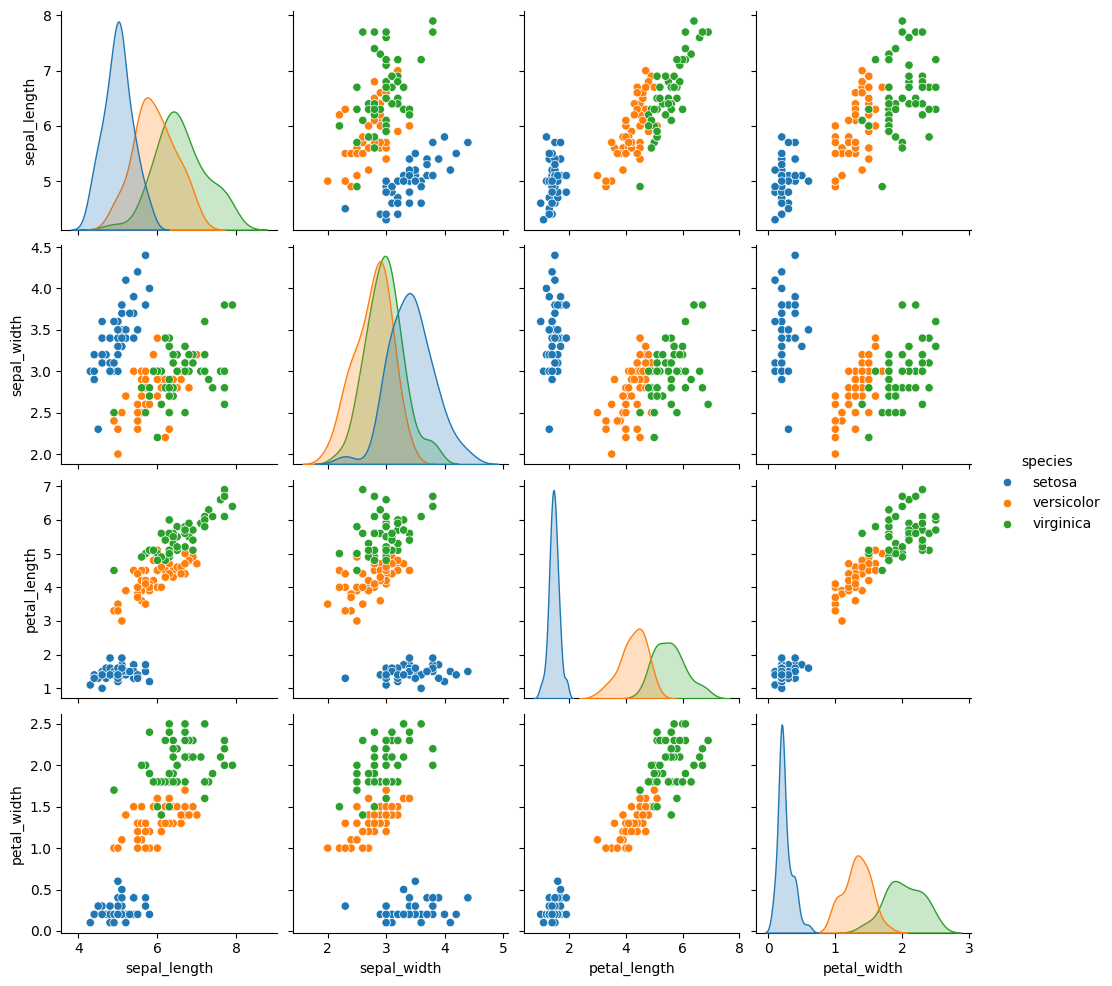

In [116]:
sns.pairplot(iris, hue='species')
plt.show()

## 2.3 Normal MoE

1. Partition the input space by feature

2. 4 features per sample in IRIS, so give each feature to an expert (fixed-routing).

3. Expert is an MLP of input_dim=1, hidden_dim=64, output_dim=3.

4. Output of MoE layer is the concatenatation of expert outputs.

5. Results found for the best learning rate on full-batch SGD.

Number of parameters in a Normal MoE layer 1331
Num train data samples for normal MoE 120


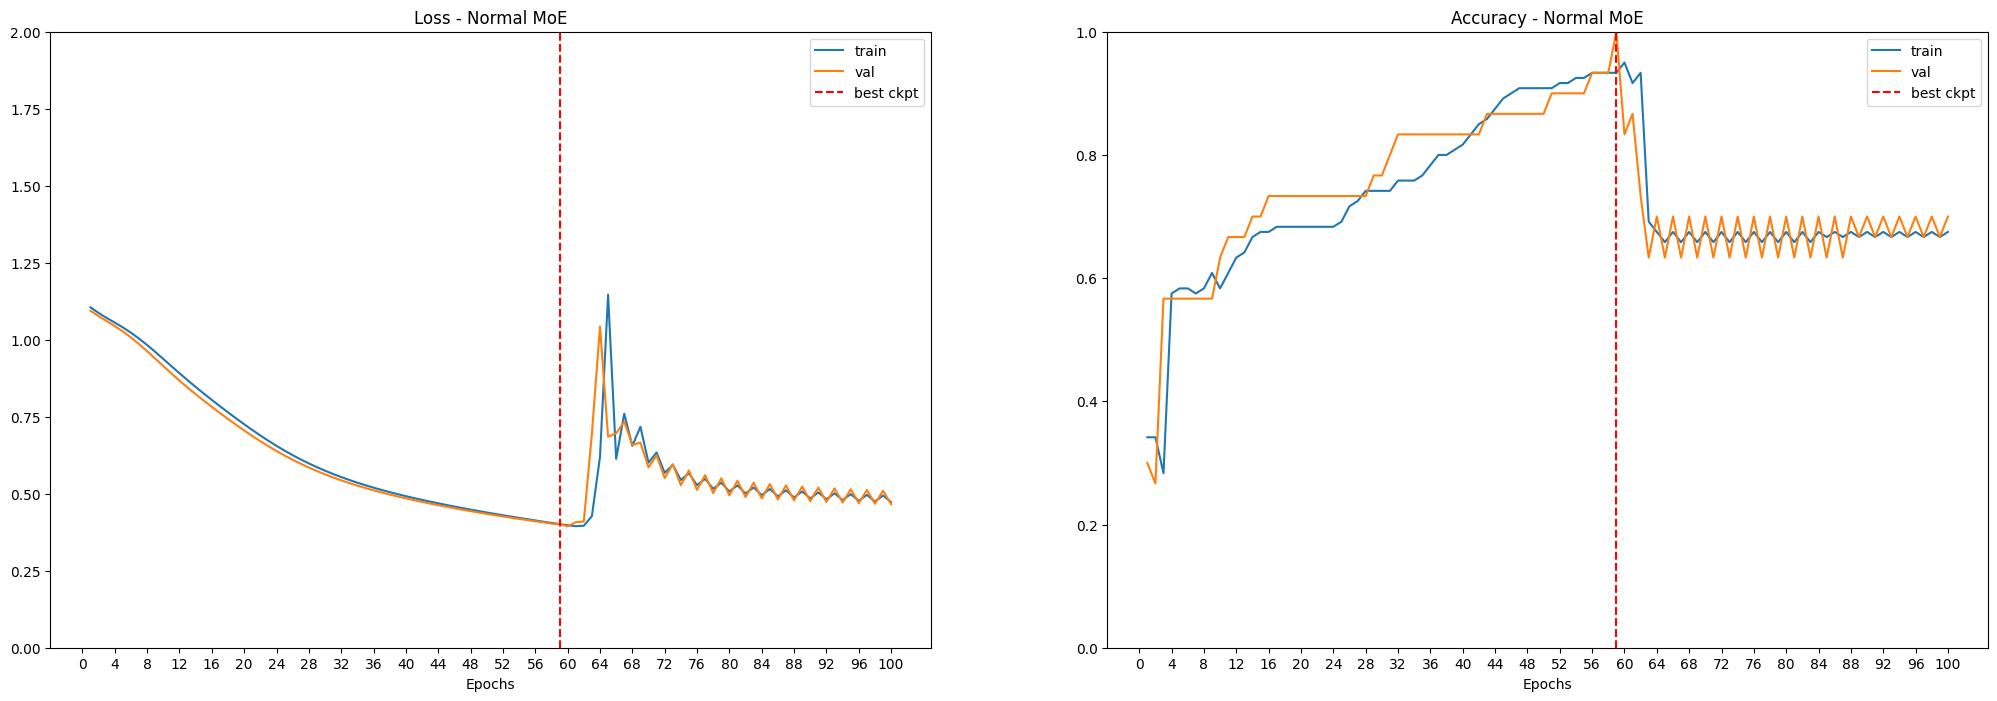

In [117]:
torch.manual_seed(0)
model = NormalMoE()

c = 0
for p in model.parameters():
    c += p.numel()

print("Number of parameters in a Normal MoE layer", c)

num_epochs = 100

num_train_samples = X_train.shape[0] // 1
train_data = torch.from_numpy(X_train[:num_train_samples, :]).float()
print("Num train data samples for normal MoE", train_data.shape[0])

train_labels = torch.from_numpy(y_train[:num_train_samples]).long()

val_data = torch.from_numpy(X_test).float()
val_labels = torch.from_numpy(y_test).long()

optimizer = torch.optim.SGD(model.parameters(), lr=4e-2, weight_decay=0.0)

store = {
    "train": {
        "loss": [],
        "accuracy": []
    },
    "val": {
        "loss": [],
        "accuracy": []
    }
}

best = 0
ckpt = None
best_idx = 0
moe_fts = None
for epoch in range(num_epochs):
    optimizer.zero_grad()

    model.train()
    train_preds = model(train_data)
    train_loss = F.cross_entropy(train_preds, train_labels)
    train_accuracy = (train_preds.argmax(dim=1) == train_labels).float().mean()

    train_loss.backward()
    optimizer.step()

    model.eval()
    val_preds = model(val_data)
    val_loss = F.cross_entropy(val_preds, val_labels)
    val_accuracy = (val_preds.argmax(dim=1) == val_labels).float().mean()


    store["train"]["loss"].append(train_loss.item())
    store["train"]["accuracy"].append(train_accuracy.item())

    store["val"]["loss"].append(val_loss.item())
    store["val"]["accuracy"].append(val_accuracy.item())

    if val_accuracy > best:
        best = val_accuracy
        best_idx = epoch+1
        ckpt = deepcopy(model)
        moe_fts = model.moe_forward(val_data).detach().clone()


# torch.save(model.state_dict(), f"iris_moe_0.pt")

epochs = [i for i in range(1, num_epochs+1)]
fig, axes = plt.subplots(1, 2, figsize=(25, 8))
axes[0].plot(epochs, store["train"]["loss"], label="train")
axes[0].plot(epochs, store["val"]["loss"], label="val")
axes[0].set_xticks(epochs)
axes[0].set_title(f"Loss - Normal MoE")
xticks = range(0, num_epochs+1, 4)
xticks = [x for x in xticks if x % 4 == 0]
axes[0].set_xticks(xticks)
axes[0].set_xticklabels([str(x) for x in xticks])
axes[0].set_xlabel("Epochs")
axes[0].set_ylim([0, 2])
axes[0].axvline(best_idx, c="r", linestyle="--", label="best ckpt")
axes[0].legend()

axes[1].plot(epochs, store["train"]["accuracy"], label="train")
axes[1].plot(epochs, store["val"]["accuracy"], label="val")
axes[1].set_xticks(epochs)
axes[1].set_title(f"Accuracy - Normal MoE")
axes[1].set_xticks(xticks)
axes[1].set_xlabel("Epochs")
axes[1].set_xticklabels([str(x) for x in xticks])
axes[1].axvline(best_idx, c="r", linestyle="--", label="best ckpt")
axes[1].set_ylim([0, 1])
axes[1].legend()

plt.show()

names = [n for n,p in ckpt.experts[0].named_parameters()]
# print(names)
moe_expert_params = [torch.cat([p.flatten() for p in expert.parameters()], dim=0).unsqueeze(0) for expert in ckpt.experts]
moe_expert_params = torch.cat(moe_expert_params, dim=0)
# print(moe_expert_params.shape)


## 2.4 Hyper-MoEs

Same MoE setup (1 expert per feature) but experts by the hypernetwork and the hypernetwork is learnt instead of the experts themselves.

Result found for the best learning rate on full-batch SGD.

Num params in a Hyper-MoE layer 12074
Num train samples for Hyper-MoE 120


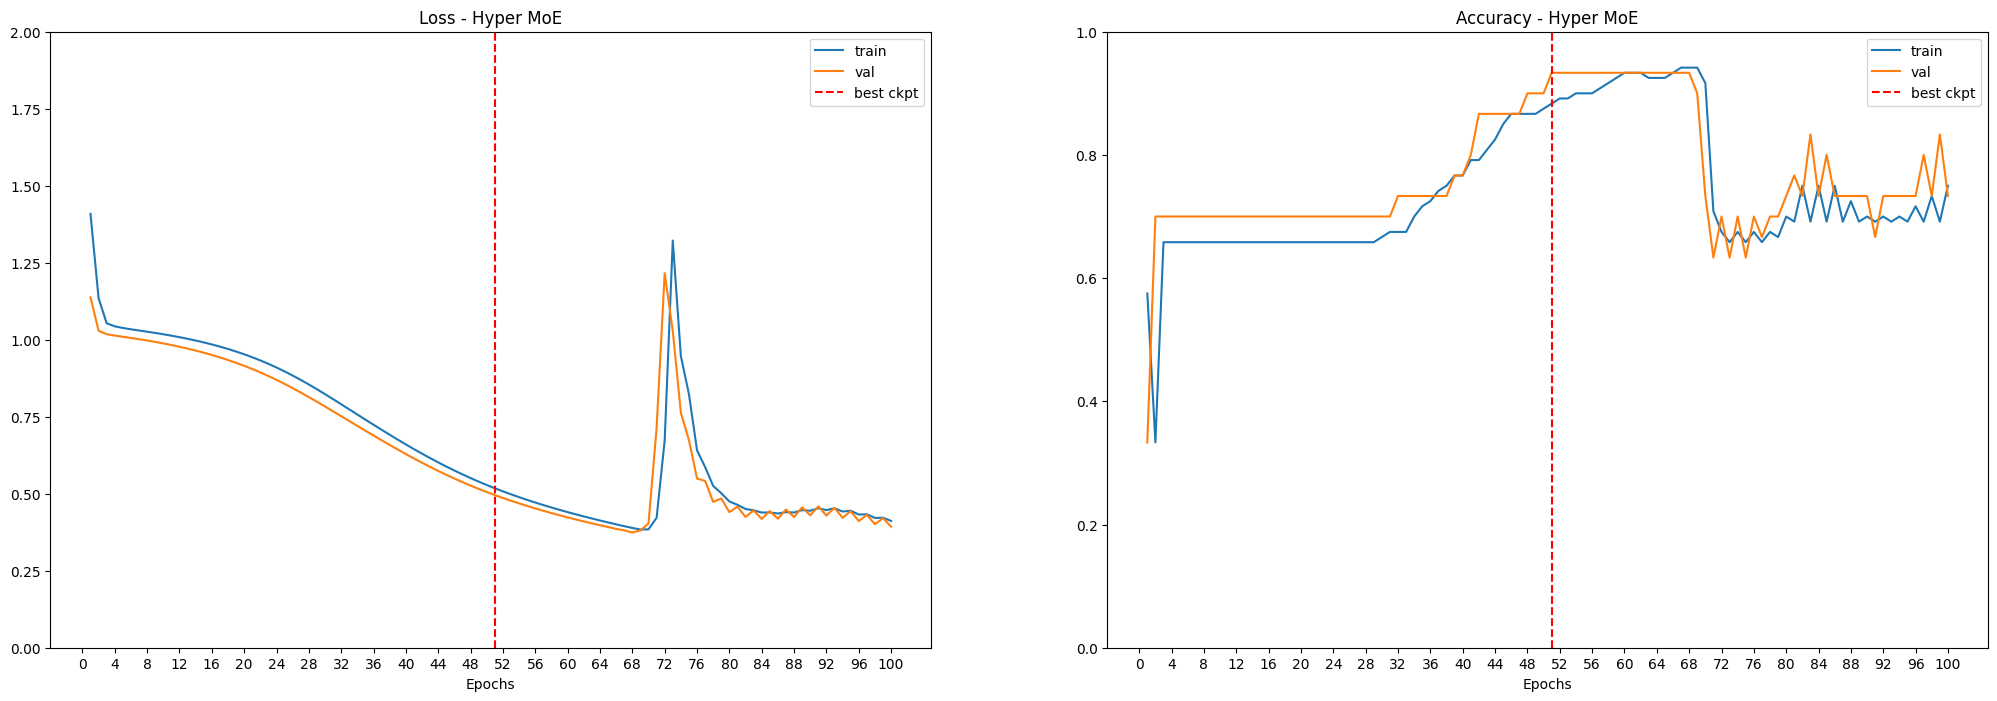

In [118]:
torch.manual_seed(0)
model = HyperMoE()

c = 0
for p in model.parameters():
    c += p.numel()

print("Num params in a Hyper-MoE layer", c)
num_epochs = 100

num_train_samples = X_train.shape[0] // 1
print("Num train samples for Hyper-MoE", num_train_samples)

train_data = torch.from_numpy(X_train).float()[:num_train_samples, :]
train_labels = torch.from_numpy(y_train).long()[:num_train_samples, ...]

val_data = torch.from_numpy(X_test).float()
val_labels = torch.from_numpy(y_test).long()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=0.1)

hstore = {
    "train": {
        "loss": [],
        "accuracy": []
    },
    "val": {
        "loss": [],
        "accuracy": []
    }
}

best = 0
ckpt = None
best_idx = 0
hmoe_fts = None
for epoch in range(num_epochs):
    optimizer.zero_grad()

    model.train()
    train_preds = model(train_data)
    train_loss = F.cross_entropy(train_preds, train_labels)
    train_accuracy = (train_preds.argmax(dim=1) == train_labels).float().mean()

    train_loss.backward()
    optimizer.step()

    model.eval()
    val_preds = model(val_data)
    val_loss = F.cross_entropy(val_preds, val_labels)
    val_accuracy = (val_preds.argmax(dim=1) == val_labels).float().mean()


    hstore["train"]["loss"].append(train_loss.item())
    hstore["train"]["accuracy"].append(train_accuracy.item())

    hstore["val"]["loss"].append(val_loss.item())
    hstore["val"]["accuracy"].append(val_accuracy.item())

    if val_accuracy > best:
        best = val_accuracy
        best_idx = epoch+1
        ckpt = deepcopy(model)
        hmoe_fts = model.moe_forward(val_data).detach().clone()

# torch.save(model.state_dict(), f"iris_moe_0.pt")

epochs = [i for i in range(1, num_epochs+1)]
fig, axes = plt.subplots(1, 2, figsize=(25, 8))
axes[0].plot(epochs, hstore["train"]["loss"], label="train")
axes[0].plot(epochs, hstore["val"]["loss"], label="val")
axes[0].axvline(best_idx, c="r", linestyle="--", label="best ckpt")
axes[0].legend()
axes[0].set_xticks(epochs)
axes[0].set_title(f"Loss - Hyper MoE")
xticks = range(0, num_epochs+1, 4)
xticks = [x for x in xticks if x % 4 == 0]
axes[0].set_xticks(xticks)
axes[0].set_xticklabels([str(x) for x in xticks])
axes[0].set_ylim([0, 2])
axes[0].set_xlabel("Epochs")

axes[1].plot(epochs, hstore["train"]["accuracy"], label="train")
axes[1].plot(epochs, hstore["val"]["accuracy"], label="val")
axes[1].axvline(best_idx, c="r", linestyle="--", label="best ckpt")
axes[1].legend()
axes[1].set_xticks(epochs)
axes[1].set_title(f"Accuracy - Hyper MoE")
axes[1].set_xticks(xticks)
axes[1].set_xticklabels([str(x) for x in xticks])
axes[1].set_xlabel("Epochs")
axes[1].set_ylim([0, 1])

plt.show()

params = ckpt.hypernetwork([0, 1, 2, 3])
hypermoe_expert_params = []
for i in range(4):
    expert_params = [
        params[0][0][i].T.flatten(),
        params[0][1][i].flatten(),
        params[1][0][i].T.flatten(),
        params[1][1][i].flatten()
    ]
    expert_params = torch.cat(expert_params, dim=0)
    hypermoe_expert_params.append(expert_params.unsqueeze(0))
hypermoe_expert_params = torch.cat(hypermoe_expert_params, dim=0)
# print(hypermoe_expert_params.shape)


### Normal v/s Hyper MoE: Val accuracy

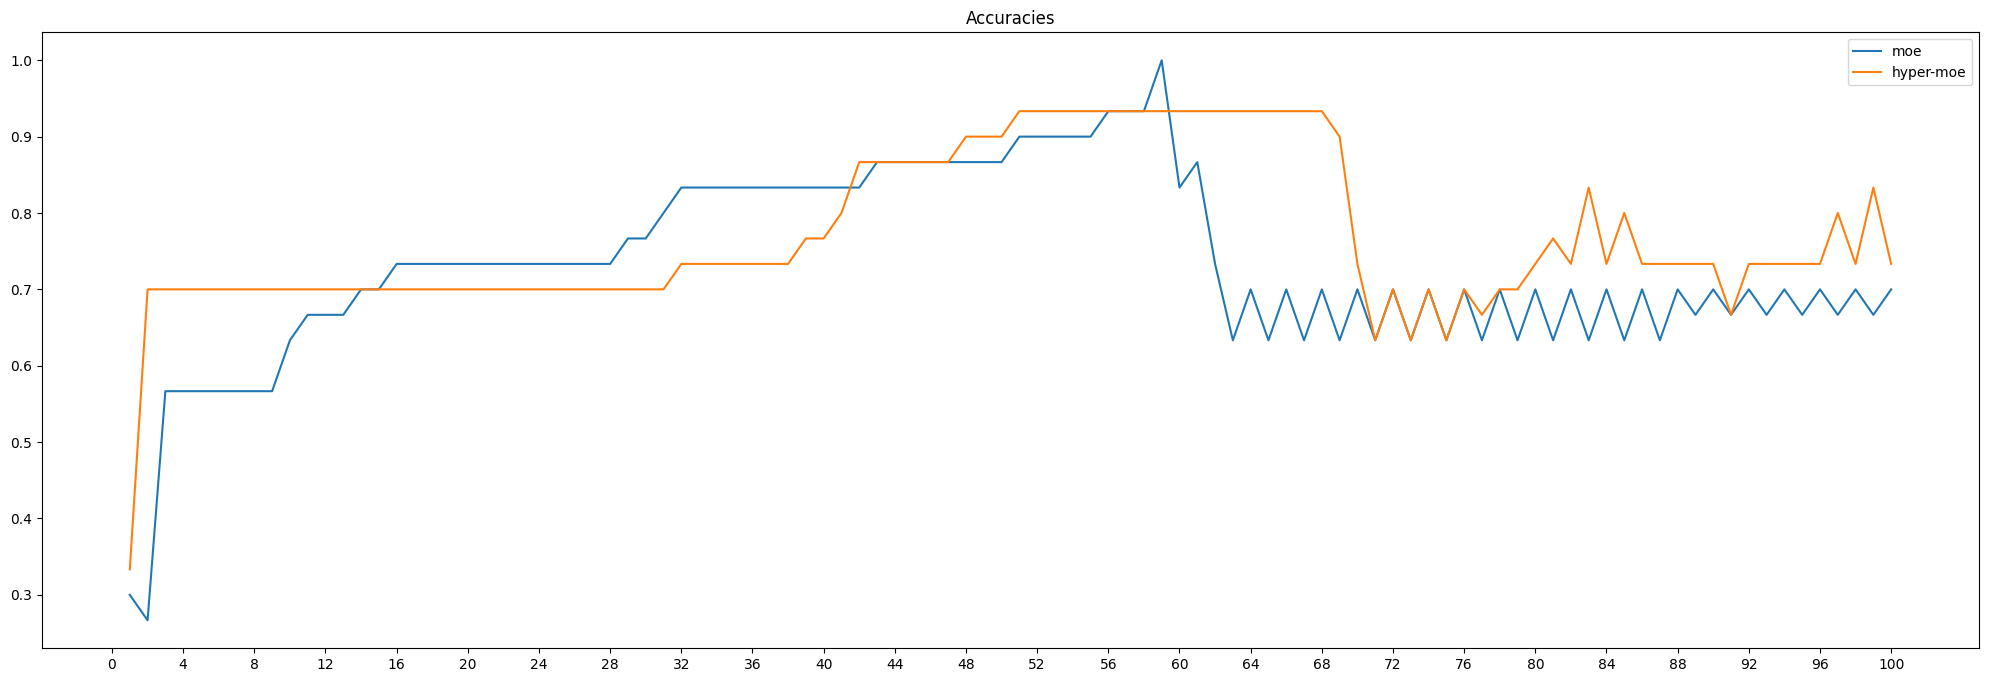

In [119]:
plt.figure(figsize=(25,8))
plt.plot([i for i in range(1,101)], store["val"]["accuracy"], label="moe")
plt.plot([i for i in range(1,101)], hstore["val"]["accuracy"], label="hyper-moe")
plt.legend()
plt.xticks([i for i in range(0, 101, 4) if i % 4 == 0])
plt.title("Accuracies")
plt.show()

### Normal v/s Hyper MoE: Val loss

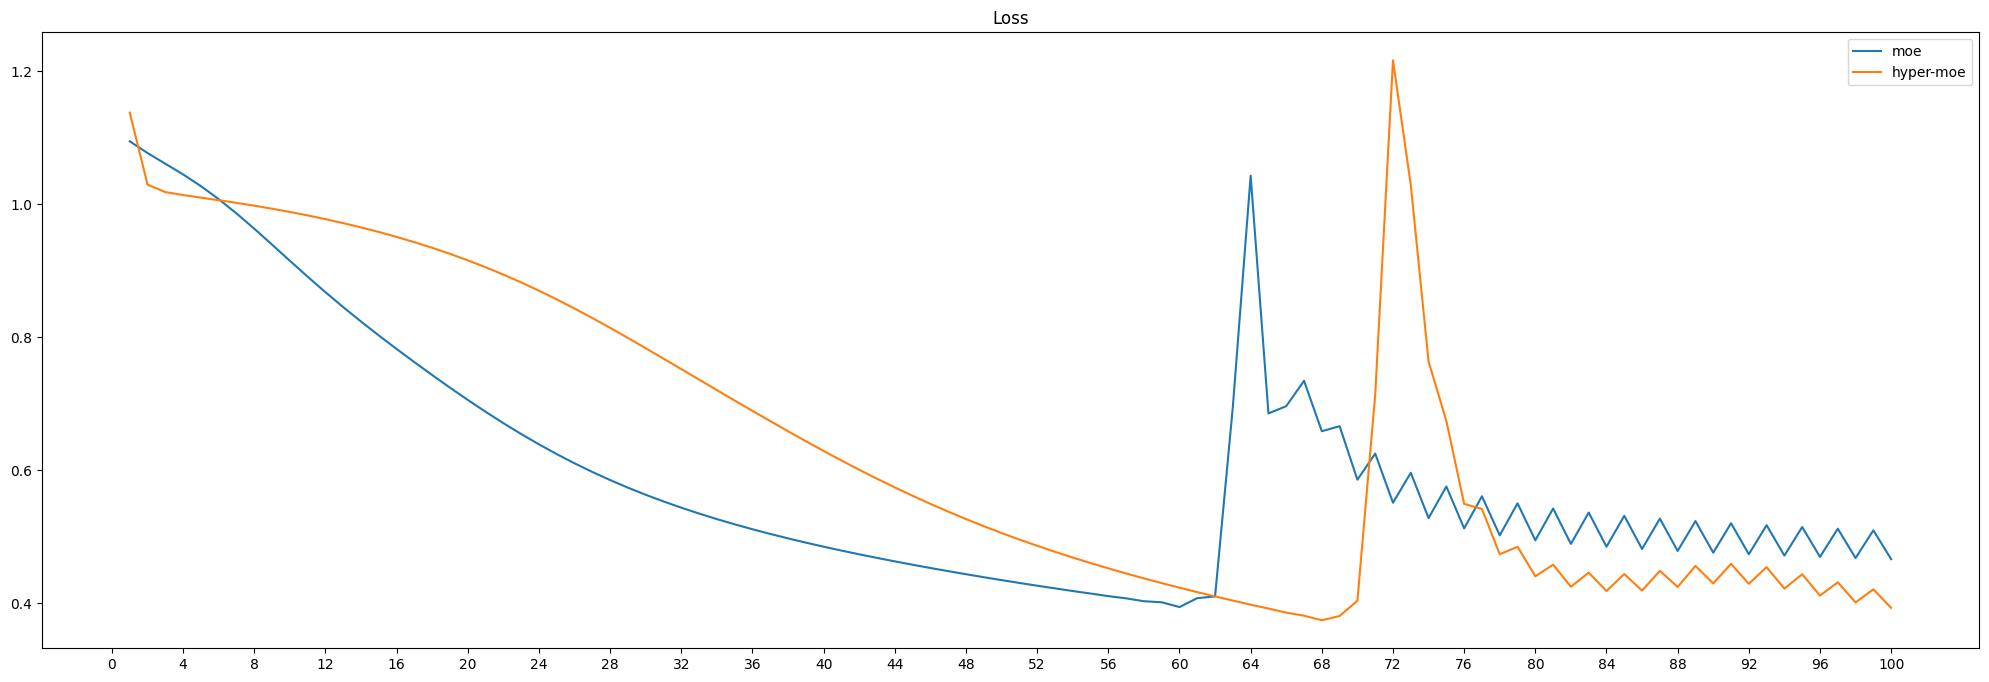

In [120]:
plt.figure(figsize=(25,8))
plt.plot([i for i in range(1,101)], store["val"]["loss"], label="moe")
plt.plot([i for i in range(1,101)], hstore["val"]["loss"], label="hyper-moe")
plt.legend()
plt.xticks([i for i in range(0, 101, 4) if i % 4 == 0])
plt.title("Loss")
plt.show()

In [121]:
moe_expert_params = moe_expert_params.detach().numpy()
hypermoe_expert_params = hypermoe_expert_params.detach().numpy()

print(moe_fts.shape)
print(hmoe_fts.shape)

torch.Size([30, 12])
torch.Size([30, 12])


## 2.5 [Analysis of Experts]: Co-variance among expert weights

We calculate and interpret:

1. The covariance within Normal MoE experts
2. The covariance within Hyper-MoE experts
3. The covariance across experts of the two types (Normal-Hyper)



### 2.5.1 Within Normal MoE experts.

**Observation**: The co-variance within normal MoE experts is fairly low among different experts.

**Conclusion**: This suggests than normal MoE experts are more distinct from each other (potentially more specialisation).

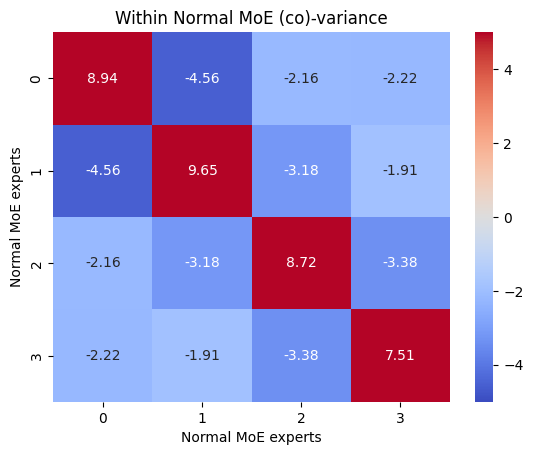

In [122]:
mean_moe = moe_expert_params.mean(axis=0)
moe_cov = (moe_expert_params - mean_moe) @ (moe_expert_params-mean_moe).T
moe_cov /= 4

sns.heatmap(moe_cov, annot=True, fmt=".2f", cmap="coolwarm", vmin=-5, vmax=5, center=0)
plt.xlabel("Normal MoE experts")
plt.ylabel("Normal MoE experts")
plt.title("Within Normal MoE (co)-variance")
plt.show()

### 2.5.2 Within Hyper-MoE experts

**Observation**: The co-variance b/w different Hyper-MoE experts is higher than those of Normal MoEs. More variable covariances as well.

**Conclusion:** This suggests that Hyper-MoE experts have strong relationships with some experts, and weak relationships with other experts.

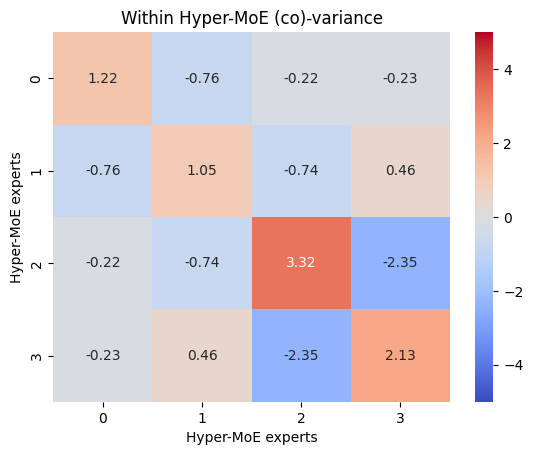

In [123]:
hmean_moe = hypermoe_expert_params.mean(axis=0)
hmoe_cov = (hypermoe_expert_params - hmean_moe) @ (hypermoe_expert_params-hmean_moe).T
hmoe_cov /= 4

sns.heatmap(hmoe_cov, annot=True, fmt=".2f", cmap="coolwarm", vmin=-5, vmax=5, center=0)
plt.xlabel("Hyper-MoE experts")
plt.ylabel("Hyper-MoE experts")
plt.title("Within Hyper-MoE (co)-variance")
plt.show()

### 2.5.3 Across expert types (Normal-Hyper)

**Observation and conclusion**: Values are fairly centered hence the two types of experts are weakly related.

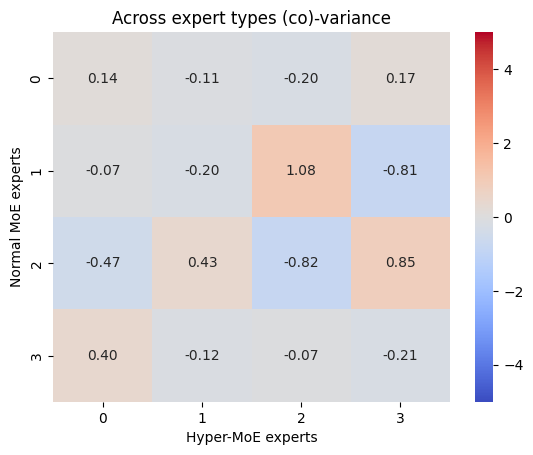

In [124]:
across_cov = (moe_expert_params - mean_moe) @ (hypermoe_expert_params-hmean_moe).T
across_cov /= 4

sns.heatmap(across_cov, annot=True, fmt=".2f", cmap="coolwarm", vmin=-5, vmax=5, center=0)
plt.xlabel("Hyper-MoE experts")
plt.ylabel("Normal MoE experts")
plt.title("Across expert types (co)-variance")
plt.show()

## 2.6 [Analysis of Experts]: Mutual information between expert weights


Mutual information between two random variables X and Y tells us how much information we get about Y when we observe X and vice-versa.

We calculate and interpret:

1. The mutual inf. within Normal MoE experts
2. The mutual inf. within Hyper-MoE experts
3. The mutual inf. across experts of the two types (Normal-Hyper)

In [125]:
from sklearn.metrics import mutual_info_score

def compute_mutual_information(x, y, bins=20):
    x_binned = np.digitize(x, bins=np.histogram_bin_edges(x, bins=bins))
    y_binned = np.digitize(y, bins=np.histogram_bin_edges(y, bins=bins))
    mi = mutual_info_score(x_binned, y_binned)
    return mi

### 2.6.1 Within Normal MoE experts

**Observation**: We seem to get significant amounts of information about expert $u$ when we observe expert $v$ where for all $u \neq v$. However, the amount of information obtained does not vary with choices of $(u, v)$.

**Conclusion**: Each expert has roughly the same relationship with each other expert.



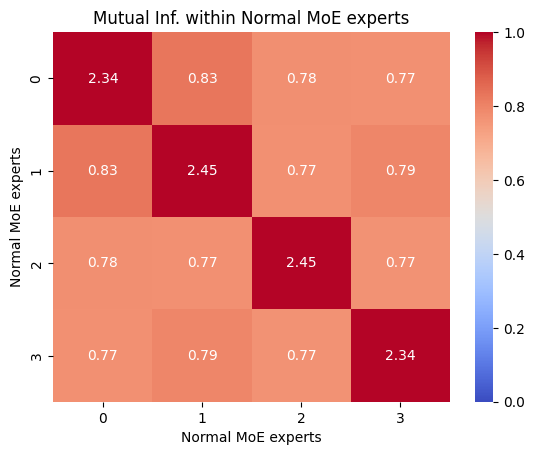

In [126]:
moe_intra_mi = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        moe_intra_mi[i][j] = compute_mutual_information(moe_expert_params[i].flatten(), moe_expert_params[j].flatten())

sns.heatmap(moe_intra_mi, annot=True, fmt=".2f", cmap="coolwarm", vmin=0, vmax=1, center=0.5)
plt.ylabel("Normal MoE experts")
plt.xlabel("Normal MoE experts")
plt.title("Mutual Inf. within Normal MoE experts")
plt.show()


### 2.6.2 Within Hyper-MoE experts

**Observation**: Hyper-MoE experts have varying amounts of mutual inf. among each other.

**Conclusion**: Every expert has quite different relationships with every other expert. Some expert-pairs have quite strong relationships, while others have quite weak ones.

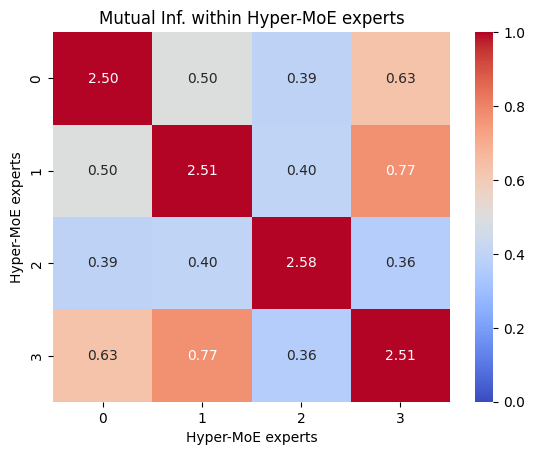

In [127]:
hypermoe_intra_mi = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        hypermoe_intra_mi[i][j] = compute_mutual_information(hypermoe_expert_params[i].flatten(), hypermoe_expert_params[j].flatten())

sns.heatmap(hypermoe_intra_mi, annot=True, fmt=".2f", cmap="coolwarm", vmin=0, vmax=1, center=0.5)
plt.ylabel("Hyper-MoE experts")
plt.xlabel("Hyper-MoE experts")
plt.title("Mutual Inf. within Hyper-MoE experts")
plt.show()

### 2.6.3 Across expert types (Normal-Hyper)

**Observation and conclusion**: No discernable relationship between experts of the two types.

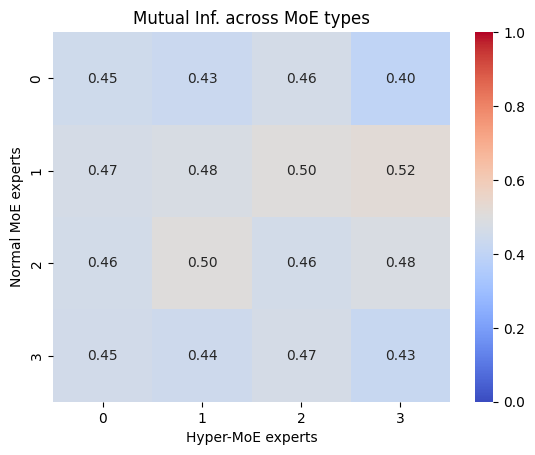

In [128]:
inter_mi = np.zeros((4, 4))
for i in range(4):
    for j in range(4):
        inter_mi[i][j] = compute_mutual_information(
            moe_expert_params[i].flatten(),
            hypermoe_expert_params[j].flatten()
        )

sns.heatmap(inter_mi, annot=True, fmt=".2f", cmap="coolwarm", vmin=0, vmax=1, center=0.5)
plt.ylabel("Normal MoE experts")
plt.xlabel("Hyper-MoE experts")
plt.title("Mutual Inf. across MoE types")
plt.show()

## 2.7 CKA between MoE Outputs

Centered Kernel Alignment (CKA) measures the similarity between two feature representations by comparing how they preserve relationships between datapoints. High CKA values indicate that the two representations capture similar patterns in the data, even if they're expressed differently (e.g., through linear or non-linear transformations). Low CKA values suggest the representations capture different aspects of the data. Linear CKA is invariant to orthogonal transformations and isotropic scaling Kernel CKA (e.g., with RBF kernel) can detect non-linear similarities between representations

Here calculate and interpret:

1. The CKA within Normal MoE outputs
2. The CKA within Normal-MoE expert params
3. The CKA within Hyper-MoE outputs
4. The CKA within Hypernetwork outputs (Hyper-MoE expert params)
5. The CKA across outputs of the two types of MoE (Normal-Hyper)
6. The CKA across the params of the two types of experts (Normal-Hyper)

In [129]:
# inspired by
# https://github.com/yuanli2333/CKA-Centered-Kernel-Alignment/blob/master/CKA.py

import math
import torch
import numpy as np

class CKA(object):
    def __init__(self):
        pass

    def centering(self, K):
        n = K.shape[0]
        unit = np.ones([n, n])
        I = np.eye(n)
        H = I - unit / n
        return np.dot(np.dot(H, K), H)

    def rbf(self, X, sigma=None):
        GX = np.dot(X, X.T)
        KX = np.diag(GX) - GX + (np.diag(GX) - GX).T
        if sigma is None:
            mdist = np.median(KX[KX != 0])
            sigma = math.sqrt(mdist)
        KX *= - 0.5 / (sigma * sigma)
        KX = np.exp(KX)
        return KX

    def kernel_HSIC(self, X, Y, sigma):
        return np.sum(self.centering(self.rbf(X, sigma)) * self.centering(self.rbf(Y, sigma)))

    def linear_HSIC(self, X, Y):
        L_X = X @ X.T
        L_Y = Y @ Y.T
        return np.sum(self.centering(L_X) * self.centering(L_Y))

    def linear_CKA(self, X, Y):
        hsic = self.linear_HSIC(X, Y)
        var1 = np.sqrt(self.linear_HSIC(X, X))
        var2 = np.sqrt(self.linear_HSIC(Y, Y))

        return hsic / (var1 * var2)

    def kernel_CKA(self, X, Y, sigma=None):
        hsic = self.kernel_HSIC(X, Y, sigma)
        var1 = np.sqrt(self.kernel_HSIC(X, X, sigma))
        var2 = np.sqrt(self.kernel_HSIC(Y, Y, sigma))

        return hsic / (var1 * var2)


### 2.7.1 Within Normal MoE experts

**Observation**: Representations of some Normal MoE experts are similar to each other, like (0, 2) and (1, 3).

**Conclusion**: To conclude from this, we need to answer the question: "do similar features indicate expert specialisation?". Because the input is different, $x_0 \neq x_1$ so the learnt function towards similar representations is different.

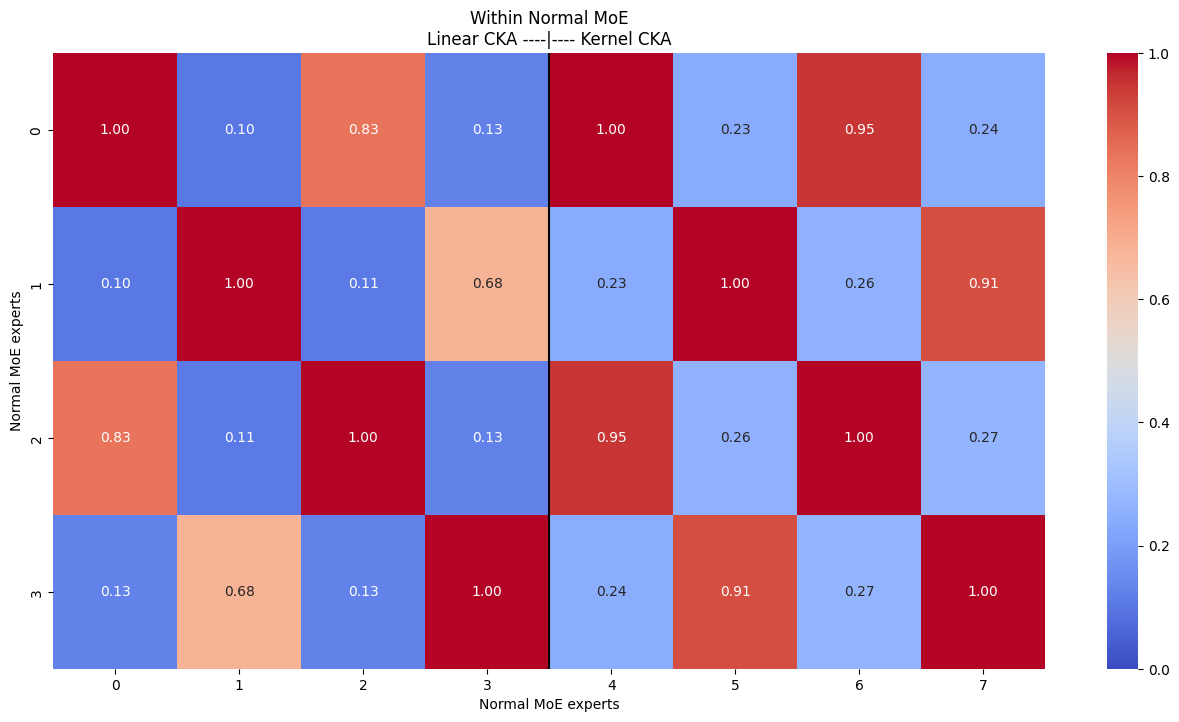

In [130]:
cka = CKA()
[N, D] = moe_fts.shape
moe_fts = moe_fts.view(4, N * D//4, 1)


moe_intra_cka = np.zeros((4, 8))
for i in range(4):
    for j in range(4):
        moe_intra_cka[i][j] = cka.linear_CKA(
            moe_fts[i], moe_fts[j]
            # moe_expert_params[i].reshape(323,1),
            # moe_expert_params[j].reshape(323,1)
        )
    for k in range(4):
        moe_intra_cka[i][4+k] = cka.kernel_CKA(
            moe_fts[i], moe_fts[k]
            # moe_expert_params[i].reshape(323,1),
            # moe_expert_params[k].reshape(323,1)
        )

plt.figure(figsize=(16, 8))
sns.heatmap(moe_intra_cka, annot=True, fmt=".2f", cmap="coolwarm", vmin=0, vmax=1, center=0.5)
plt.axvline(4, c="black")
plt.ylabel("Normal MoE experts")
plt.xlabel("Normal MoE experts")
plt.title("Within Normal MoE\nLinear CKA ----|---- Kernel CKA")
plt.show()

### 2.7.2 Within Normal MoE experts (params)

**Observation**: Normal MoE experts are strong dissimilar and matches the pattern in mutual inf. and co-variance. Note this may not be entirely correct because CKA is used to measure similarity between activations/features and not the parameter matrices.

**Conclusion**: Indicates specialisation and low information-sharing among experts.

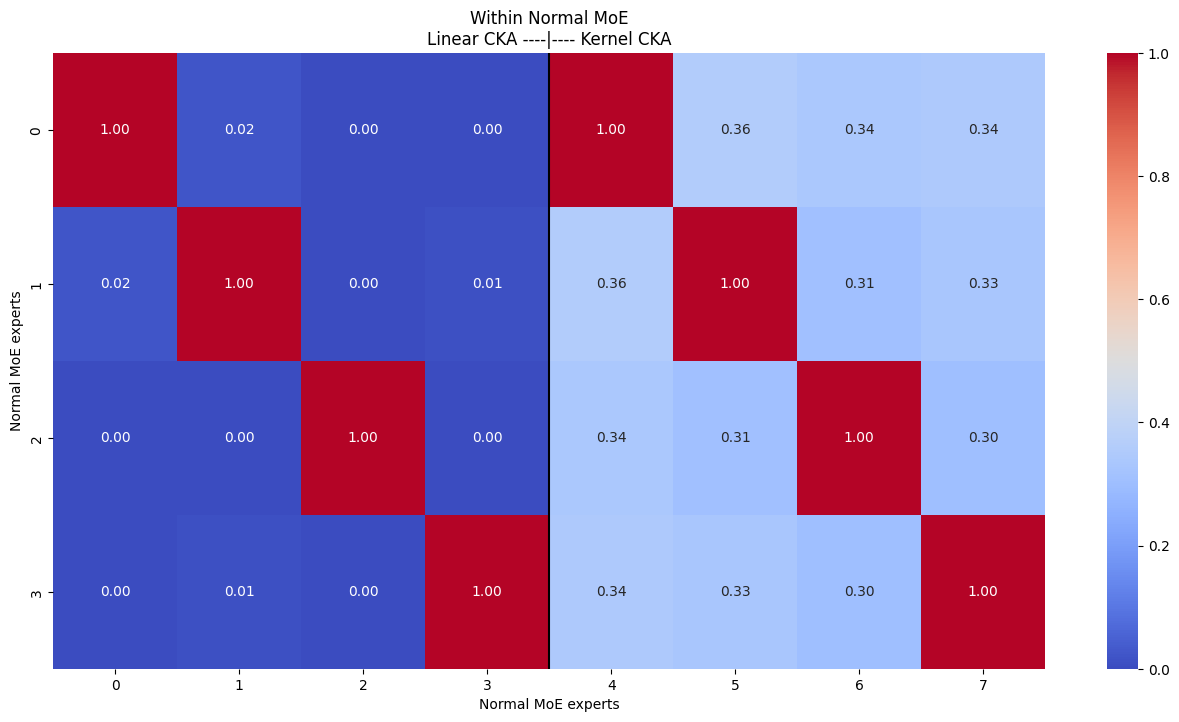

In [135]:
cka = CKA()
# [N, D] = moe_fts.shape
# moe_fts = moe_fts.view(4, N * D//4, 1)


moe_intra_cka = np.zeros((4, 8))
for i in range(4):
    for j in range(4):
        moe_intra_cka[i][j] = cka.linear_CKA(
            # moe_fts[i], moe_fts[j]
            moe_expert_params[i].reshape(323,1),
            moe_expert_params[j].reshape(323,1)
        )
    for k in range(4):
        moe_intra_cka[i][4+k] = cka.kernel_CKA(
            # moe_fts[i], moe_fts[k]
            moe_expert_params[i].reshape(323,1),
            moe_expert_params[k].reshape(323,1)
        )

plt.figure(figsize=(16, 8))
sns.heatmap(moe_intra_cka, annot=True, fmt=".2f", cmap="coolwarm", vmin=0, vmax=1, center=0.5)
plt.axvline(4, c="black")
plt.ylabel("Normal MoE experts")
plt.xlabel("Normal MoE experts")
plt.title("Within Normal MoE\nLinear CKA ----|---- Kernel CKA")
plt.show()

### 2.7.3 Within Hyper-MoE experts (outputs)

**Observation**: Hyper-MoE experts show the same pattern like Normal Moe experts show with the addition of (0, 3) and (2, 3).

**Conclusion**: This suggests that there is more sharing of information between expert representations as compared to Normal MoE.

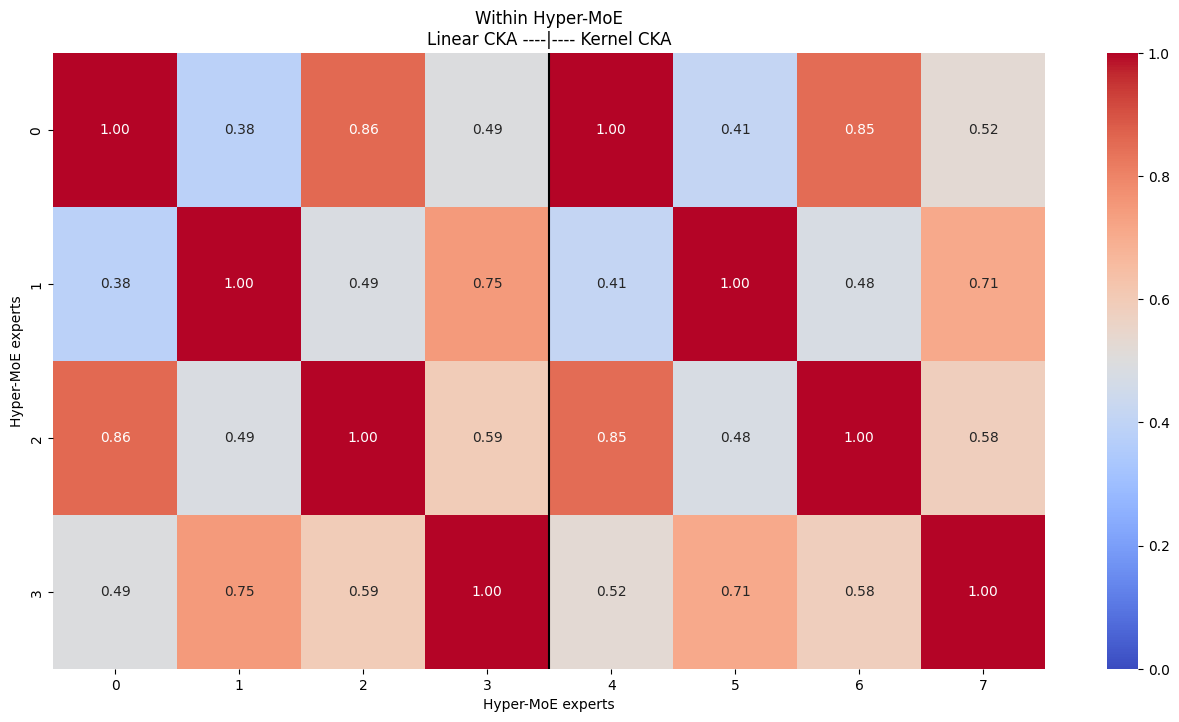

In [131]:
[N, D] = hmoe_fts.shape
hmoe_fts = hmoe_fts.view(4, N * D//4, 1)

hmoe_intra_cka = np.zeros((4, 8))
for i in range(4):
    for j in range(4):
        hmoe_intra_cka[i][j] = cka.linear_CKA(
            hmoe_fts[i], hmoe_fts[j]
            # hypermoe_expert_params[i].reshape(323,1),
            # hypermoe_expert_params[j].reshape(323,1)
        )
    for k in range(4):
        hmoe_intra_cka[i][4+k] = cka.kernel_CKA(
            hmoe_fts[i], hmoe_fts[k]
            # hypermoe_expert_params[i].reshape(323,1),
            # hypermoe_expert_params[k].reshape(323,1)
        )

plt.figure(figsize=(16, 8))
sns.heatmap(hmoe_intra_cka, annot=True, fmt=".2f", cmap="coolwarm", vmin=0, vmax=1, center=0.5)
plt.axvline(4, c="black")
plt.ylabel("Hyper-MoE experts")
plt.xlabel("Hyper-MoE experts")
plt.title("Within Hyper-MoE\nLinear CKA ----|---- Kernel CKA")
plt.show()

### 2.7.4 Within Hyper-MoE experts (params)

**Observation**: CKA within Hyper-MoE expert params shows the same pattern like that in co-variance and mutual information.

**Conclusion**: This shows that Hyper-MoE experts have more similarities in them than Normal MoE experts => less specialisation.

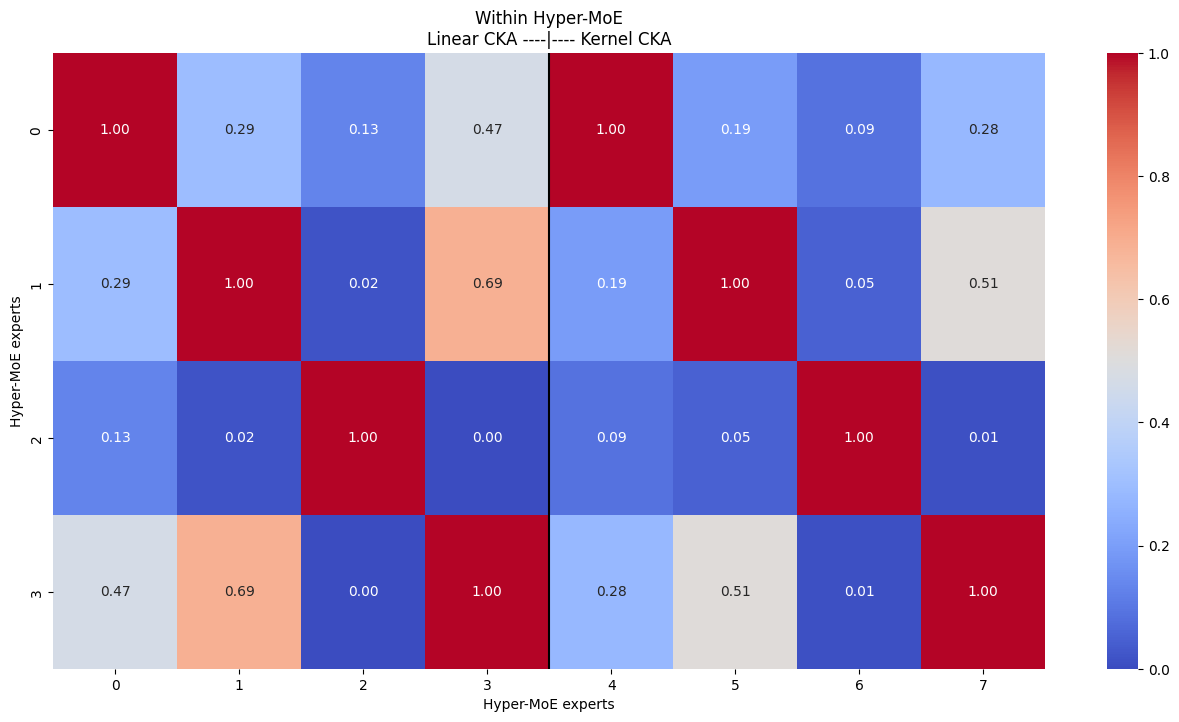

In [134]:
# [N, D] = hmoe_fts.shape
# hmoe_fts = hmoe_fts.view(4, N * D//4, 1)

hmoe_intra_cka = np.zeros((4, 8))
for i in range(4):
    for j in range(4):
        hmoe_intra_cka[i][j] = cka.linear_CKA(
            # hmoe_fts[i], hmoe_fts[j]
            hypermoe_expert_params[i].reshape(323,1),
            hypermoe_expert_params[j].reshape(323,1)
        )
    for k in range(4):
        hmoe_intra_cka[i][4+k] = cka.kernel_CKA(
            # hmoe_fts[i], hmoe_fts[k]
            hypermoe_expert_params[i].reshape(323,1),
            hypermoe_expert_params[k].reshape(323,1)
        )

plt.figure(figsize=(16, 8))
sns.heatmap(hmoe_intra_cka, annot=True, fmt=".2f", cmap="coolwarm", vmin=0, vmax=1, center=0.5)
plt.axvline(4, c="black")
plt.ylabel("Hyper-MoE experts")
plt.xlabel("Hyper-MoE experts")
plt.title("Within Hyper-MoE\nLinear CKA ----|---- Kernel CKA")
plt.show()

### 2.7.5 Across MoE expert types (Normal-Hyper) (outputs)

**Observation and conclusion:** Normal MoE expert representations are weakly related with Hyper-MoE experts.

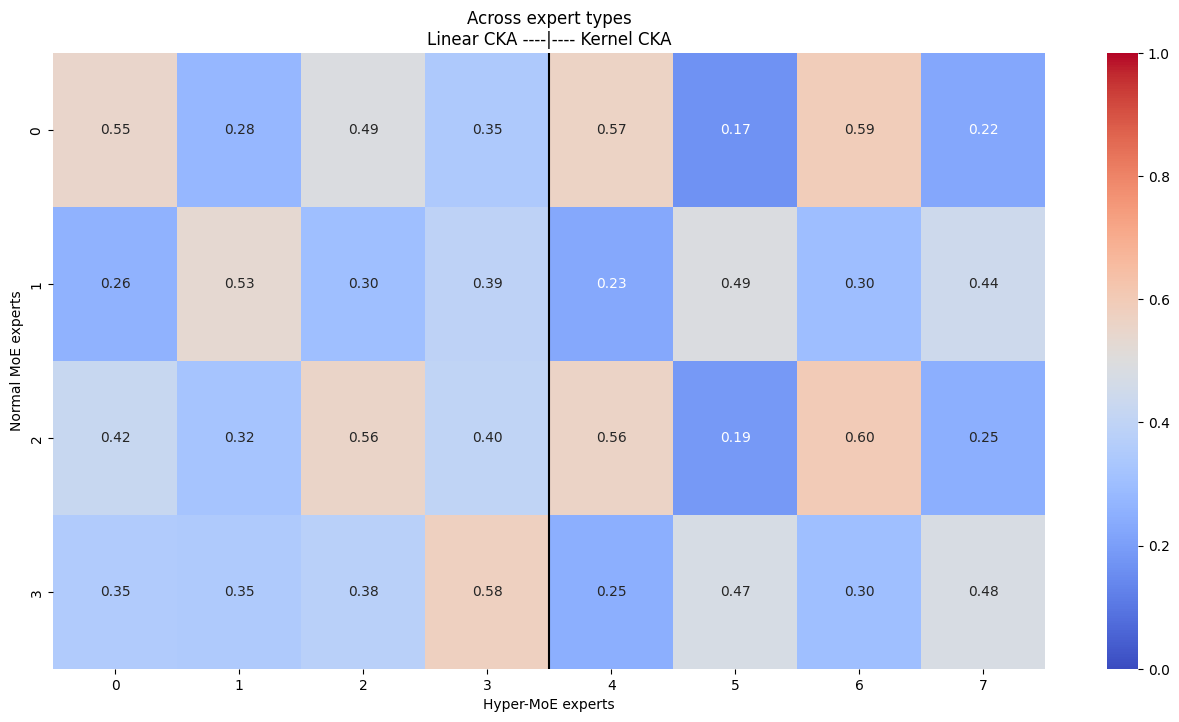

In [133]:
intra_cka = np.zeros((4, 8))
for i in range(4):
    for j in range(4):
        intra_cka[i][j] = cka.linear_CKA(
            moe_fts[i], hmoe_fts[j]
            # moe_expert_params[i].reshape(323,1),
            # hypermoe_expert_params[j].reshape(323,1)
        )
    for k in range(4):
        intra_cka[i][4+k] = cka.kernel_CKA(
            moe_fts[i], hmoe_fts[k]
            # moe_expert_params[i].reshape(323,1),
            # hypermoe_expert_params[k].reshape(323,1)
        )

plt.figure(figsize=(16, 8))
sns.heatmap(intra_cka, annot=True, fmt=".2f", cmap="coolwarm", vmin=0, vmax=1, center=0.5)
plt.axvline(4, c="black")
plt.ylabel("Normal MoE experts")
plt.xlabel("Hyper-MoE experts")
plt.title("Across expert types\nLinear CKA ----|---- Kernel CKA")
plt.show()

### 2.7.6 Across MoE expert types (Normal-Hyper) (params)

**Observation and conclusion:** Normal MoE expert params are completely different from Hyper-MoE experts.

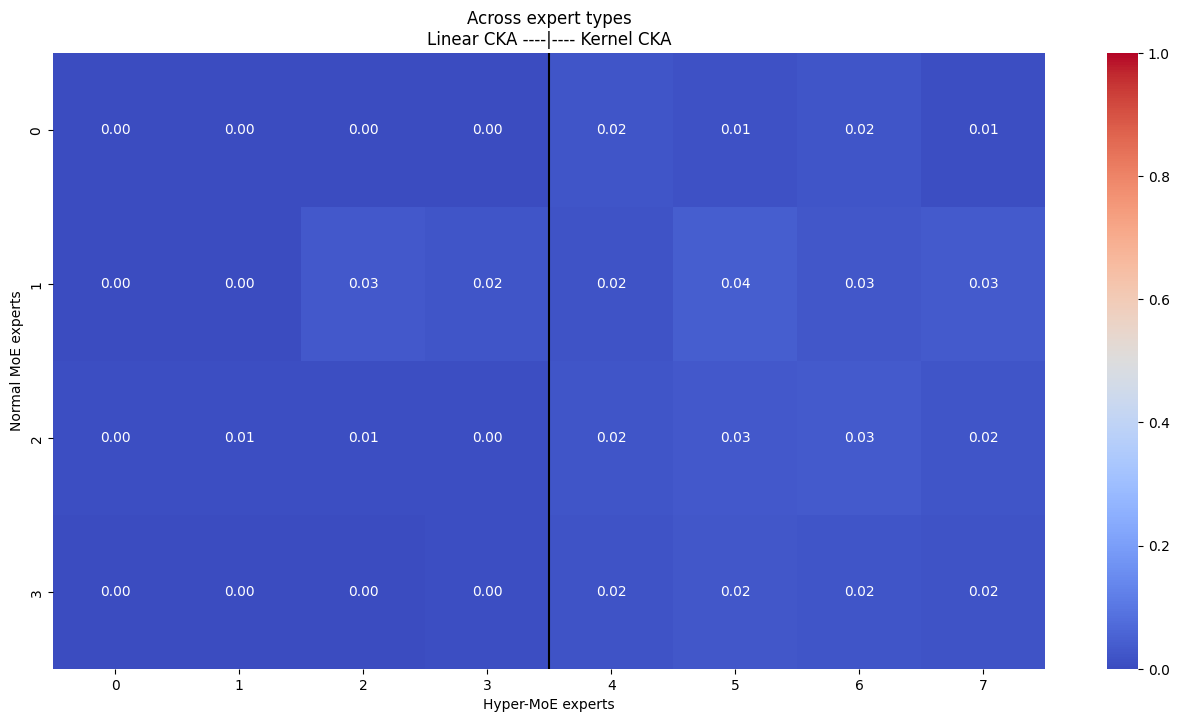

In [136]:
intra_cka = np.zeros((4, 8))
for i in range(4):
    for j in range(4):
        intra_cka[i][j] = cka.linear_CKA(
            # moe_fts[i], hmoe_fts[j]
            moe_expert_params[i].reshape(323,1),
            hypermoe_expert_params[j].reshape(323,1)
        )
    for k in range(4):
        intra_cka[i][4+k] = cka.kernel_CKA(
            # moe_fts[i], hmoe_fts[k]
            moe_expert_params[i].reshape(323,1),
            hypermoe_expert_params[k].reshape(323,1)
        )

plt.figure(figsize=(16, 8))
sns.heatmap(intra_cka, annot=True, fmt=".2f", cmap="coolwarm", vmin=0, vmax=1, center=0.5)
plt.axvline(4, c="black")
plt.ylabel("Normal MoE experts")
plt.xlabel("Hyper-MoE experts")
plt.title("Across expert types\nLinear CKA ----|---- Kernel CKA")
plt.show()

# 3.0 Questions, clarifications, & recommendations.

Please add any questions, things to clarify, or recommendations in this text block.